# Visualizing Wiener processes

Let's start with a basic Wiener process with no drift.

100%|██████████| 500/500 [00:13<00:00, 38.10it/s]


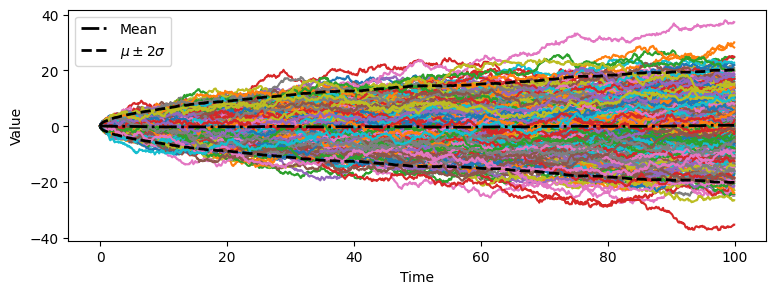

In [1]:
import numpy as np
from tqdm import tqdm

from quant_learn.stochastic_processes.wiener import GeneralizedWiener as Wiener

# Initialize Wiener process
wiener_1d_no_drift = Wiener(infinitesimal_time_interval=0.1, seed=1234)

# Run it a bunch of times
num_simulations = 500
num_steps = 1000
for _ in tqdm(range(num_simulations)):
    wiener_1d_no_drift.simulate(num_steps=num_steps)

# Let's compute mean and covariances
timestamps = wiener_1d_no_drift.simulation_history[0][0]
mean = np.mean(np.array([values for _, values in wiener_1d_no_drift.simulation_history]), axis=0)
covariance = np.cov(np.array([values for _, values in wiener_1d_no_drift.simulation_history]).T)

fig, axes = wiener_1d_no_drift.plot_runs(figsize=(9, 3))
axes.plot(timestamps, mean, 'k-.', linewidth = 2, label='Mean')
axes.plot(timestamps, 2 * np.sqrt(covariance.diagonal()),
          'k--', linewidth = 2, label=r'$\mu \pm 2\sigma$')
axes.plot(timestamps, -2 * np.sqrt(covariance.diagonal()),
          'k--', linewidth = 2)
_ = axes.legend()

Let's verify if the variance follows what we expect.

Slope: 1.0209704656874121
Intercept: -0.40207104162500684
R-squared: 0.9973815516138675


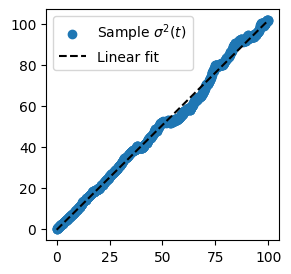

In [2]:
from matplotlib import pyplot as plt
from scipy.stats import linregress

result = linregress(x=timestamps, y=covariance.diagonal())
print(f'Slope: {result.slope}')
print(f'Intercept: {result.intercept}')
print(f'R-squared: {result.rvalue}')

fit = (timestamps * result.slope) + result.intercept

fig, axes = plt.subplots(1, 1, figsize=(3, 3))
axes.scatter(timestamps, covariance.diagonal(), label=r'Sample $\sigma^2(t)$')
axes.plot(timestamps, fit, 'k--', label='Linear fit')
_ = axes.legend()

It would also be interesting to check that $Cov(W_t, W_s) = min(t, s)$... Since we ran a limited amount of simulations, let's give somewhat ample tolerance based on the time interval.

In [3]:
for i, t in enumerate(timestamps):
    for j, s in enumerate(timestamps[i+1:], start=i+1):
        cov = covariance[i,j]
        tol = 0.05 * abs(t - s)
        assert np.allclose(cov, min(t, s), atol=tol, rtol=0.1), f'Cov_{i,j} = {cov} != {min(t, s)}'

Now, if we have a constant positive drift, we expect the mean to increase linearly with time.

100%|██████████| 500/500 [00:13<00:00, 37.66it/s]


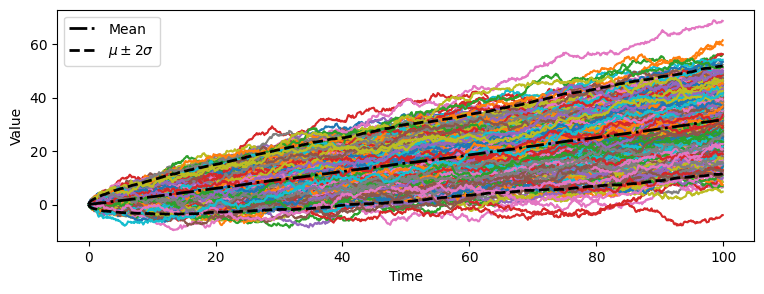

In [4]:
from quant_learn.utils.funcs import ConstantFunction

# Initialize Wiener process
drift_value = 0.314159
drift = ConstantFunction(constant=drift_value)
wiener_1d_drift = Wiener(infinitesimal_time_interval=0.1,
                         drift=drift,
                         seed=1234)

# Run it a bunch of times
num_simulations = 500
num_steps = 1000
for _ in tqdm(range(num_simulations)):
    wiener_1d_drift.simulate(num_steps=num_steps)

# Let's compute mean and covariances
timestamps = wiener_1d_drift.simulation_history[0][0]
mean = np.mean(np.array([values for _, values in wiener_1d_drift.simulation_history]), axis=0)
covariance = np.cov(np.array([values for _, values in wiener_1d_drift.simulation_history]).T)

fig, axes = wiener_1d_drift.plot_runs(figsize=(9, 3))
axes.plot(timestamps, mean, 'k-.', linewidth = 2, label='Mean')
axes.plot(timestamps, mean + 2 * np.sqrt(covariance.diagonal()),
          'k--', linewidth = 2, label=r'$\mu \pm 2\sigma$')
axes.plot(timestamps, mean - 2 * np.sqrt(covariance.diagonal()),
          'k--', linewidth = 2)
_ = axes.legend()

Once again, let's make sure the mean and variances obey what we expect.

Drift fit
Slope: 0.3170193772388586
Intercept: -0.2787831265716125
R-squared: 0.9999055635747276
Variance fit
Slope: 1.0209704656874121
Intercept: -0.40207104162499974
R-squared: 0.9973815516138675


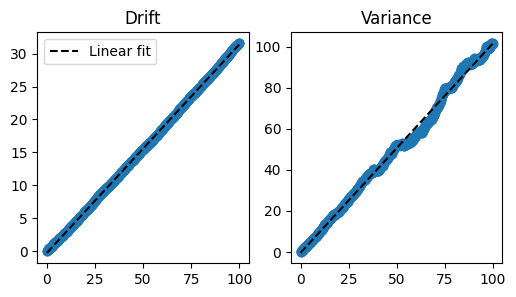

In [8]:
measured_drift = linregress(x=timestamps, y=mean)
assert np.allclose(measured_drift.slope, drift_value, rtol=0.01), \
    f'Measured drift = {measured_drift.slope} != {drift_value}'
drift_fit = (timestamps * measured_drift.slope) + measured_drift.intercept
print('Drift fit')
print(f'Slope: {measured_drift.slope}')
print(f'Intercept: {measured_drift.intercept}')
print(f'R-squared: {measured_drift.rvalue}')
print('===================================')

result = linregress(x=timestamps, y=covariance.diagonal())
print('Variance fit')
print(f'Slope: {result.slope}')
print(f'Intercept: {result.intercept}')
print(f'R-squared: {result.rvalue}')

fit = (timestamps * result.slope) + result.intercept

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].set_title('Drift')
axes[0].scatter(timestamps, mean)
axes[0].plot(timestamps, drift_fit, 'k--', label='Linear fit')
axes[1].set_title('Variance')
axes[1].scatter(timestamps, covariance.diagonal(), label=r'Sample $\sigma^2(t)$')
axes[1].plot(timestamps, fit, 'k--', label='Linear fit')
_ = axes[0].legend()

for i, t in enumerate(timestamps):
    for j, s in enumerate(timestamps[i+1:], start=i+1):
        cov = covariance[i,j]
        tol = 0.05 * abs(t - s)
        assert np.allclose(cov, min(t, s), atol=tol, rtol=0.1), f'Cov_{i,j} = {cov} != {min(t, s)}'